# Image classifiers

In [ ]:
# Imports to be used through the notebook

import torch 
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import time

import os, datetime

import utils
import archis

from autoattack import AutoAttack

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Data (MNIST)

In [3]:
# We define a transformation to apply to the items of the dataset (that are, by default, in PIL image format). The standardization will help with training.

MEAN_MNIST = (0.1307,)
STD_MNIST = (0.3081,)

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN_MNIST, STD_MNIST)])

transform_mnist_unnormalized = transforms.Compose([
    transforms.ToTensor()])


trainset = torchvision.datasets.MNIST(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=True,
                                        download=True, transform=transform_mnist_unnormalized)

testset = torchvision.datasets.MNIST(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=False,
                                       download=True, transform=transform_mnist_unnormalized)


#trainset.__len__() # yields 60000
#trainset.__getitem__(0) # tuple (image, class); image is a tensor 1x28x28 and class is an int
#trainset.__getitem__(0)[0].shape #yields torch.Size([1, 28, 28])

In [4]:
# Trainloaders are dataset wrappers used to access them in a batched way. Of course this is very useful for NN training.
batch_size = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print("Size train loader: ", len(trainloader), " | test loader: ", len(testloader))

Size train loader:  118  | test loader:  20


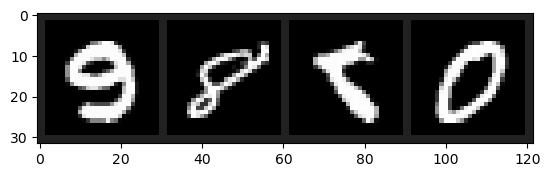

Labels:      9             8             8             0 

Image shape (number of channels, height, width): (1, 28, 28)


In [ ]:
# functions to show an image un the normalized MNIST case
def imshow(img):
    img = img * STD_MNIST[0] + MEAN_MNIST[0]  # Proper unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # MNIST is grayscale + original tensor shape is (1,28,28) so  np.transpose(img, (1, 2, 0)) gets it to shape (28,28,1) 
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)  # batches are lists of two tensors, one containing features and other labels.
images, labels = images[:4], labels[:4] 

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:     ','             '.join(f'{labels[j]}' for j in range(4)), '\n')
print(f'Image shape (number of channels, height, width): {tuple(images[0].shape)}')

## Data (CIFAR-10)

In [6]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2471, 0.2435, 0.2616]

transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])


trainset_cifar10 = torchvision.datasets.CIFAR10(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=True,
                                        download=True, transform=transform_cifar10)

testset_cifar10 = torchvision.datasets.CIFAR10(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=False,
                                       download=True, transform=transform_cifar10)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
batch_size = 256

trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print("Size train loader: ", len(trainloader_cifar10), " | test loader: ", len(testloader_cifar10))

Size train loader:  196  | test loader:  40


## Load model

MNIST architecture


In [5]:
import archis
model = archis.SimpleCNN(input_channels=1, output_channels=10)
model.load_state_dict(torch.load('Models\MNISTsmall-unnormalized.pt'))
model.to(device)
model.eval()

SimpleCNN(
  (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1690, out_features=10, bias=True)
)

CIFAR-10 architecture (resnet-34)

In [9]:
import archis

model_cifar = archis.resnet34(pretrained=True).to(device)

# Results on MNIST

## Example of attack

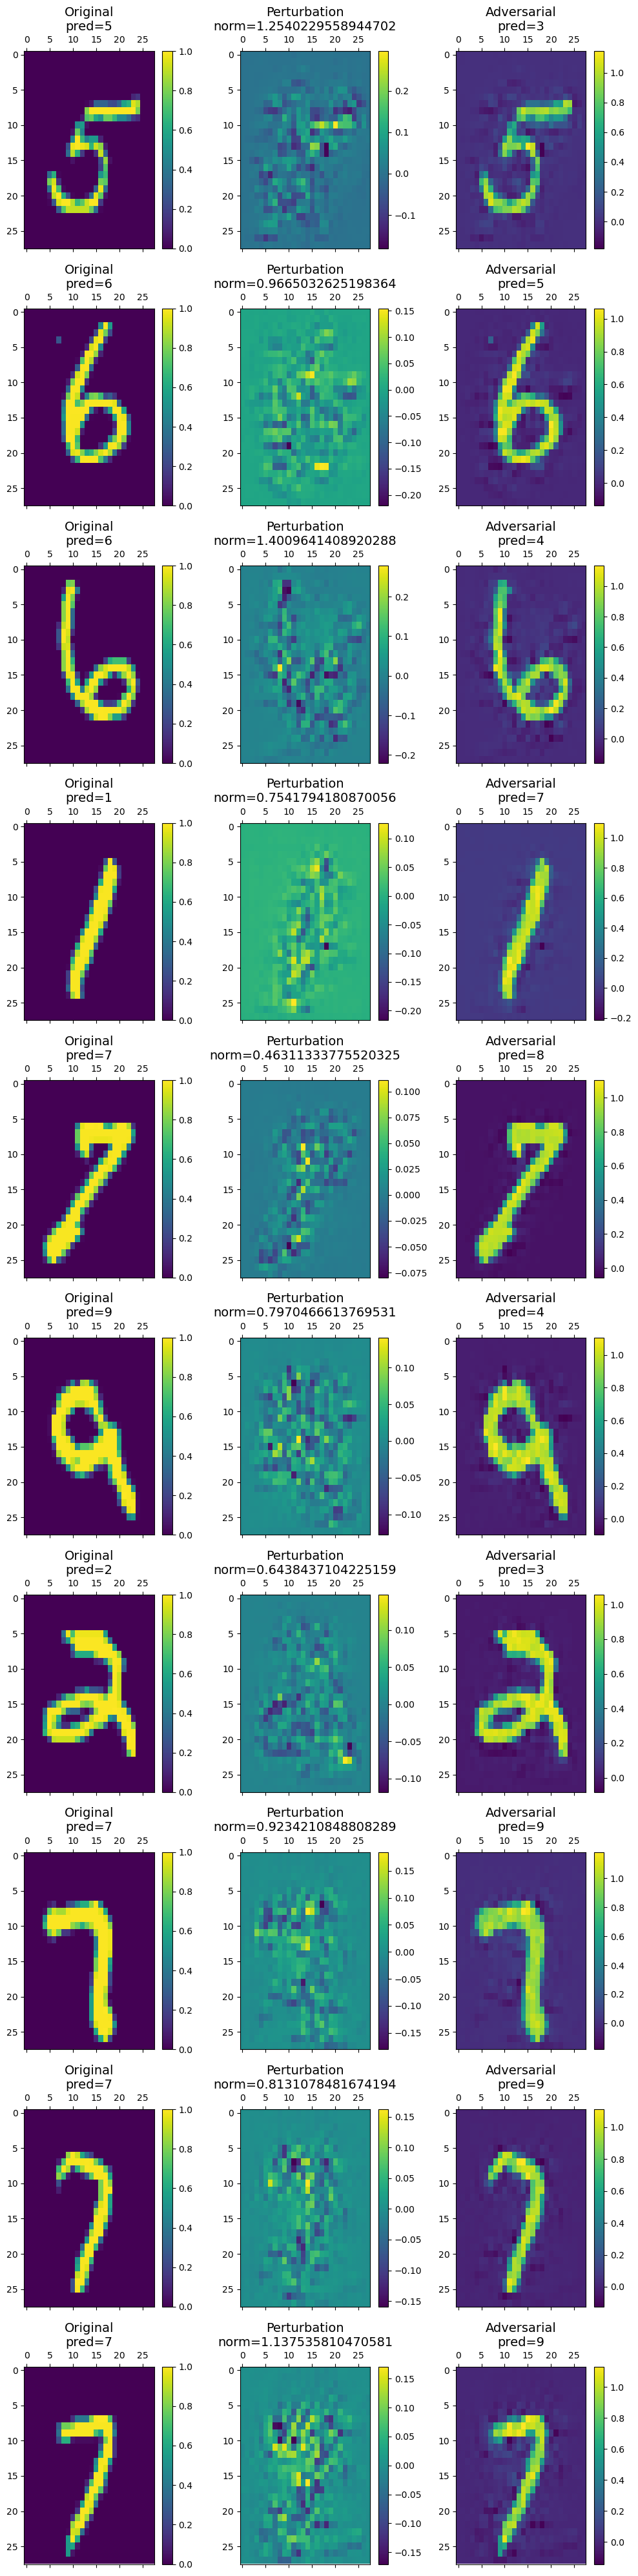

In [21]:
x_batch, y_batch = next(iter(trainloader)) 
x_batch = x_batch[0:10].to(device)
y_batch = y_batch[0:10].to(device)

utils.attack_examples(model=model, images=x_batch, labels=y_batch, attack=utils.ocf_attack_until_flip, nb_examples=10)

## Attack testing

### Loop: budget control version

In [ ]:
import torch
from tqdm.auto import tqdm                

# -----------------------------------------------------------
# 0.  Setup
# -----------------------------------------------------------
device = next(model.parameters()).device      # 'cuda:0' or 'cpu'

nb_step_grid      = range(1, 101, 10)             # 1 … 100
total_budget_grid = range(3, 11, 2)              # 3 … 10
n_settings        = len(nb_step_grid) * len(total_budget_grid)

n_images  = len(testloader.dataset)
n_classes = 10                                 # 10 for MNIST, adapt this later

# -----------------------------------------------------------
# 1.  Pre‑allocate storage
# -----------------------------------------------------------
all_logits = torch.empty(
    len(nb_step_grid), len(total_budget_grid), n_images, n_classes,
    dtype=torch.float32, device=device
)
correct = torch.zeros(len(nb_step_grid), len(total_budget_grid),
                      dtype=torch.int32, device=device)
total   = torch.zeros_like(correct)

# -----------------------------------------------------------
# 2.  Main evaluation loop with progress
# -----------------------------------------------------------
with torch.no_grad():
    global_idx = 0

    # Outer bar: iterate once over the test set
    for batch_idx, (images, labels) in enumerate(
            tqdm(testloader, desc="Batches", position=0)):

        images, labels = images.to(device), labels.to(device)
        batch_size     = images.size(0)

        # Nested bars for the hyper‑parameter sweep
        for i_nb, nb_steps in enumerate(
                tqdm(nb_step_grid, desc="nb_steps", position=1, leave=False)):

            for j_tb, total_budget in enumerate(
                    tqdm(total_budget_grid, desc="budget", position=2, leave=False)):

                adv_images = utils.ocf_attack(model, images, attacked_class=2,
                                        nb_steps=nb_steps,
                                        total_budget=total_budget)

                logits = model(adv_images)

                # Store logits
                all_logits[i_nb, j_tb,
                           global_idx:global_idx + batch_size] = logits

                # Update accuracy counters
                preds = logits.argmax(dim=1)
                correct[i_nb, j_tb] += (preds == labels).sum().to(correct.dtype)
                total[i_nb,  j_tb]  += torch.tensor(batch_size, dtype=correct.dtype,
                                                    device=device)

        global_idx += batch_size
        '''
        # ---- quick console feedback every 10 batches ---------------------------
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(testloader):
            print(f"Processed {global_idx}/{n_images} images "
                  f"({(100*global_idx/n_images):.1f} %)")
        '''
# -----------------------------------------------------------
# 3.  Compute accuracy
# -----------------------------------------------------------
accuracy = correct.float() / total
print("\nSweep finished!")
print("Accuracy grid shape:", accuracy.shape)    # should be (100, 8)

# 4‑A.  Make a results folder
os.makedirs("results", exist_ok=True)

# 4‑B.  Build a nice filename with a timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
ckpt_path = f"results/adv_sweep_{timestamp}.pt"

# 4‑C.  Move tensors to CPU and (optionally) cast to half to save space
ckpt = {
    "logits"        : all_logits.cpu(),              # or .half() to halve size
    "correct"       : correct.cpu(),
    "total"         : total.cpu(),
    "accuracy"      : accuracy.cpu(),
    "nb_steps"      : torch.tensor(list(nb_step_grid)),
    "total_budgets" : torch.tensor(list(total_budget_grid)),
}

torch.save(ckpt, ckpt_path)
print(f"\n✔ Saved checkpoint to: {ckpt_path}")


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

nb_steps:   0%|          | 0/10 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Result visualization (budget version)

Loading results\adv_sweep_20250513_142543.pt


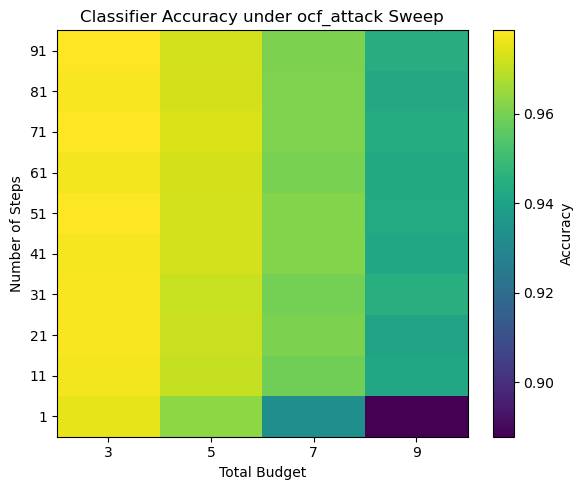

In [18]:
import os, torch, matplotlib.pyplot as plt, numpy as np

# -----------------------------------------------------------
# 1.  Locate the newest checkpoint
# -----------------------------------------------------------
ckpt_path = "results"                     # adjust if needed
files = [f for f in os.listdir(ckpt_path) if f.endswith(".pt")]
assert files, "No .pt files found - check ckpt_path!"

latest     = max(files, key=lambda f: os.path.getmtime(os.path.join(ckpt_path, f)))
ckpt_file  = os.path.join(ckpt_path, latest)
print("Loading", ckpt_file)

# -----------------------------------------------------------
# 2.  Load the accuracy grid & axes 
# -----------------------------------------------------------
ckpt      = torch.load(ckpt_file, map_location="cpu")
accuracy  = ckpt["accuracy"].numpy()                # shape (len(nb_steps) × len(budgets))
nb_steps  = ckpt["nb_steps"].numpy()                # e.g. [1, 11, … , 91]
budgets   = ckpt["total_budgets"].numpy()           # e.g. [3, 5, 7, 9]

# -----------------------------------------------------------
# 3.  Plot a heat‑map
# -----------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.imshow(accuracy, aspect='auto', origin='lower')     # default colormap
plt.colorbar(label="Accuracy")
plt.xticks(ticks=np.arange(len(budgets)),  labels=budgets)
plt.yticks(ticks=np.arange(len(nb_steps)), labels=nb_steps)
plt.xlabel("Total Budget")
plt.ylabel("Number of Steps")
plt.title("Classifier Accuracy under ocf_attack Sweep")
plt.tight_layout()
plt.show()

### Loop: while version

In [7]:
results = utils.eval_loop(model, testloader, utils.ocf_attack_until_flip, device)

Evaluating:   0%|          | 0/20 [00:00<?, ?batch/s]

### Result visualization

In [8]:
results

{'accuracy': 0.9836,
 'adv_accuracy': 0.0133,
 'flipped_pct': 1.0,
 'norms': tensor([0.8951, 0.8842, 0.6823,  ..., 0.9477, 0.7414, 1.1033]),
 'confidences': tensor([13.4489, 11.9859,  8.0763,  ..., 14.1869, 12.4799, 15.9780]),
 'labels': tensor([7, 2, 1,  ..., 4, 5, 6])}

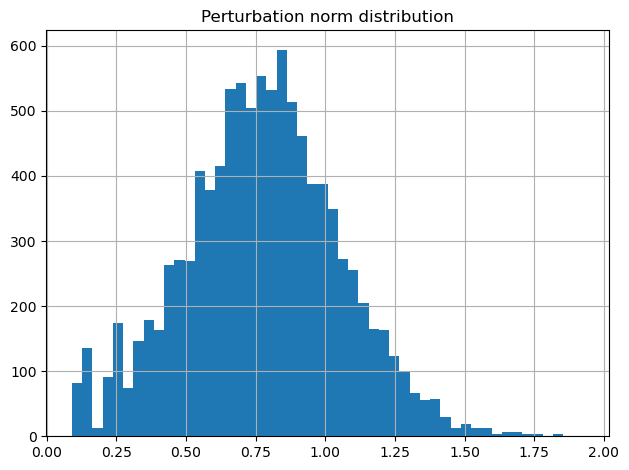

In [9]:
#Histogram

norms = results["norms"].numpy()

plt.hist(norms, bins=50)
plt.title("Perturbation norm distribution")
plt.grid(True)
plt.tight_layout()
plt.show()


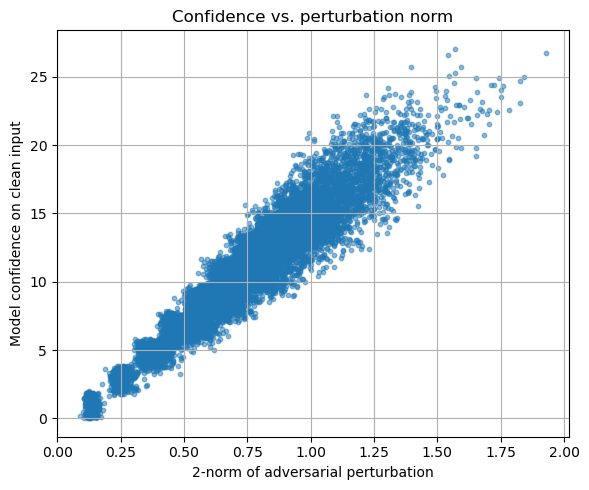

In [10]:
norms = results["norms"].numpy()
confidences = results["confidences"].numpy()

plt.figure(figsize=(6, 5))
plt.scatter(norms, confidences, s=10, alpha=0.5)
plt.xlabel("2-norm of adversarial perturbation")
plt.ylabel("Model confidence on clean input")
plt.title("Confidence vs. perturbation norm")
plt.grid(True)
plt.tight_layout()
plt.show()

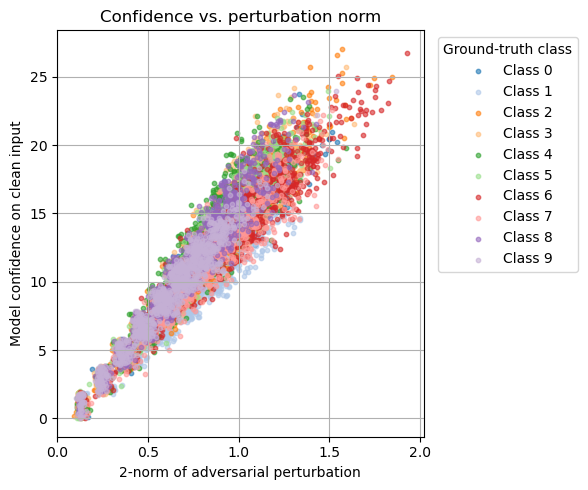

In [11]:
norms = results["norms"].numpy()
confidences = results["confidences"].numpy()
labels = results["labels"].numpy()

classes = np.unique(labels)
cmap    = plt.get_cmap("tab20")

plt.figure(figsize=(6, 5))

for i, cls in enumerate(classes):
    mask = labels == cls
    plt.scatter(
        norms[mask],
        confidences[mask],
        s=10,
        alpha=0.6,
        color=cmap(i % cmap.N),
        label=f"Class {cls}"
    )

plt.xlabel("2-norm of adversarial perturbation")
plt.ylabel("Model confidence on clean input")
plt.title("Confidence vs. perturbation norm")
plt.grid(True)
plt.legend(title="Ground-truth class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Results on CIFAR-10

In [10]:
dataiter = iter(trainloader_cifar10)
images, labels = next(dataiter)  # batches are lists of two tensors, one containing features and other labels.
images, labels = images[:4], labels[:4] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


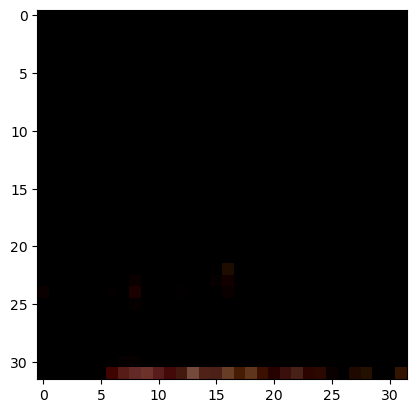

In [11]:
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
plt.show()

In [12]:
results = utils.eval_loop(model_cifar, testloader_cifar10, utils.ocf_attack_until_flip, device)

Evaluating:   0%|          | 0/40 [00:04<?, ?batch/s]

In [13]:
results

{'accuracy': 0.9333,
 'adv_accuracy': 0.0295,
 'flipped_pct': 1.0,
 'norms': tensor([ 10.6218,  62.2770,   8.8422,  ...,  38.7295, 112.0476, 203.4765]),
 'confidences': tensor([5.6827, 6.2820, 5.6981,  ..., 5.3585, 5.7675, 6.0256]),
 'labels': tensor([3, 8, 8,  ..., 5, 1, 7])}

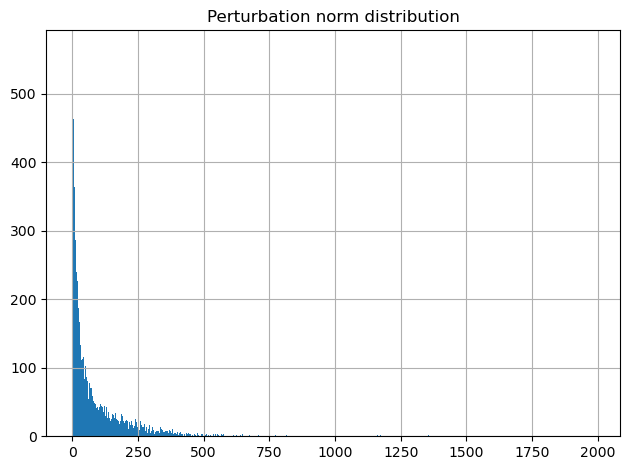

In [14]:
#Histogram

norms = results["norms"].numpy()

plt.hist(norms, bins=1000)
plt.title("Perturbation norm distribution")
plt.grid(True)
plt.tight_layout()
plt.show()


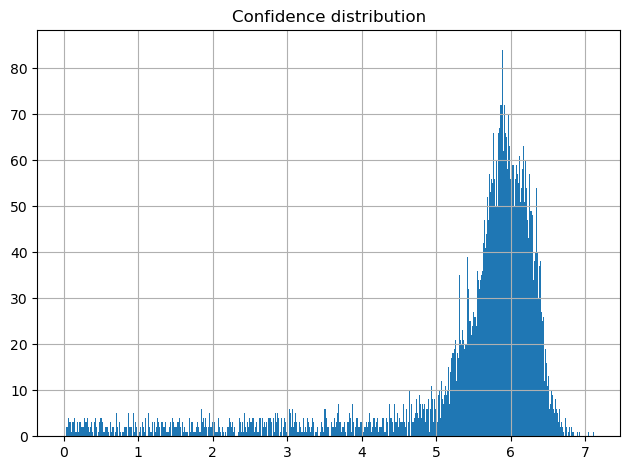

In [15]:
#Histogram

confidences = results["confidences"].numpy()

plt.hist(confidences, bins=1000)
plt.title("Confidence distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

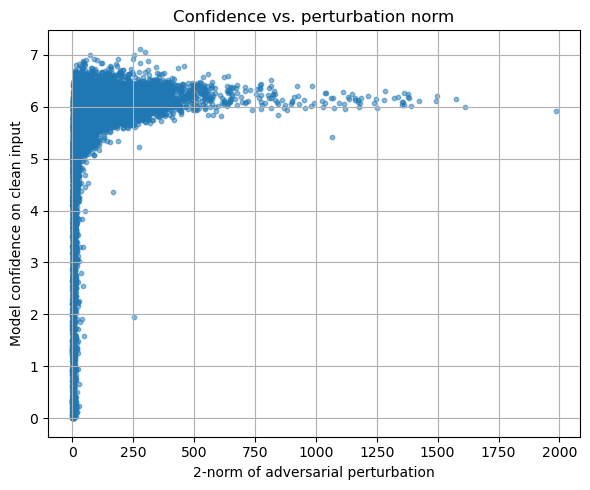

In [16]:
norms = results["norms"].numpy()
confidences = results["confidences"].numpy()

plt.figure(figsize=(6, 5))
plt.scatter(norms, confidences, s=10, alpha=0.5)
plt.xlabel("2-norm of adversarial perturbation")
plt.ylabel("Model confidence on clean input")
plt.title("Confidence vs. perturbation norm")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(torch.argmax(results["norms"])) #7383

print(results["norms"][7383])
print(results["confidences"][7383])



tensor(7383)
tensor(1985.2148)
tensor(5.9087)


In [7]:
x_batch, y_batch = next(iter(testloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [11]:
np.min(utils.comparable_norm(x_batch).to('cpu').numpy())

0.15742049

In [21]:
np.sqrt(utils.flat(x_batch).shape[1])

55.42562584220407

In [ ]:
confidences = utils.step_estimator(model=model_cifar, batch=x_batch)

attacks = utils.ocf_attack_until_flip(model_cifar, x_batch)

perturbations = attacks -  x_batch

In [30]:
def batchnorm(tensor):
    # Assumes tensor shape is [B, C, H, W]
    flat_tensor = utils.flat(tensor)

    return torch.linalg.norm(flat_tensor, dim=1, ord=2)

In [42]:
a = torch.arange(9, dtype=torch.float) - 4
a = a.unsqueeze(0)
b = torch.cat((a, a, a), dim=0)
print(b[0]==a)
print(batchnorm(b))

tensor([[True, True, True, True, True, True, True, True, True]])
tensor([7.7460, 7.7460, 7.7460])


In [29]:
B = 256
print(x_batch.view(B, -1).shape)
print(utils.flat(x_batch).shape)
torch.equal(x_batch.view(B, -1), utils.flat(x_batch))

torch.Size([256, 3072])
torch.Size([256, 3072])


True

In [ ]:
x_single = images[0].unsqueeze(0).to(device)

model_cifar()

tensor([[-0.8366, -1.0328, -0.5224,  5.5120, -0.5529,  0.4641, -0.5562, -0.6547,
         -0.8798, -0.9409]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Experiments

In [22]:
eps=0.5
adversary = AutoAttack(model, norm='L2', eps=1, version='standard')

setting parameters for standard version


In [23]:
x_adv = adversary.run_standard_evaluation(x_batch, y_batch, bs=10)

using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 100.00%
apgd-ce - 1/1 - 6 out of 10 successfully perturbed
robust accuracy after APGD-CE: 40.00% (total time 0.4 s)
apgd-t - 1/1 - 0 out of 4 successfully perturbed
robust accuracy after APGD-T: 40.00% (total time 5.8 s)
fab-t - 1/1 - 0 out of 4 successfully perturbed
robust accuracy after FAB-T: 40.00% (total time 17.8 s)
square - 1/1 - 0 out of 4 successfully perturbed
robust accuracy after SQUARE: 40.00% (total time 57.0 s)
max L2 perturbation: 0.99979, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 40.00%
